# MNIST Classification using ResNet-18 network

### Importing neccessary libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sn
import pandas as pd
import numpy as np

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Preparing the dataset

For every image the following transformation is applied:
- image is converted to tensor
- image is randomly rotated by an angle between -10 and 10 providing data augmentation
- image is normalized using mean equal 0.1307 and standard deviation 0.3081 (Mean and deviation are the calculated on all pixel values of train MNIST dataset)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation((-10, 10)),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, 
                                            shuffle=True, num_workers=2)
# Load test data
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                            shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Defining the model

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu2(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.relu = nn.ReLU()
        self.adapool = nn.AdaptiveAvgPool2d((1, 1))
        self.sigmoid = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.adapool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out


def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

## Defining evaluation metrics

In [7]:
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average="macro")

def get_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average="macro")

def build_confusion_matrix(y_true, y_pred):
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in CLASSES],
                        columns = [i for i in CLASSES])
    return df_cm


def plot_confusion_matrix(confusion_matrix_dataframe):
    plt.figure(figsize = (12,7))
    sn.heatmap(confusion_matrix_dataframe, annot=True, fmt='d')
    plt.show()

# Training

In [8]:
# Define the ResNet16 model
model = resnet18().to(device=DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

max_val_accuracy = None

# Train the model
for epoch in range(10):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))
    
    # Evaluate model after every epoch on validation set
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.to(device=DEVICE)
                labels = labels.to(device=DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
                y_pred.extend(output)

                labels = labels.data.cpu().numpy()
                y_true.extend(labels)

        print("Validation set metrics:")
        print('Accuracy: %.2f%%' % (100 * get_accuracy(y_true, y_pred)))
        print('Precision: %.2f%%' % (100 * get_precision(y_true, y_pred)))
        print('Recall: %.2f%%' % (100 * get_recall(y_true, y_pred)))
        print()
        # if the model has the highest accuracy on validation set save it
        if max_val_accuracy is None or max_val_accuracy < get_accuracy(y_true, y_pred):
          max_val_accuracy = get_accuracy(y_true, y_pred)
          compiled_model = torch.jit.script(model)
          compiled_model.save("model.pt")

Epoch 1 loss: 1.581
Validation set metrics:
Accuracy: 98.04%
Precision: 98.02%
Recall: 98.06%

Epoch 2 loss: 1.477
Validation set metrics:
Accuracy: 98.21%
Precision: 98.20%
Recall: 98.20%

Epoch 3 loss: 1.472
Validation set metrics:
Accuracy: 98.45%
Precision: 98.46%
Recall: 98.42%

Epoch 4 loss: 1.469
Validation set metrics:
Accuracy: 98.98%
Precision: 98.97%
Recall: 98.97%

Epoch 5 loss: 1.467
Validation set metrics:
Accuracy: 98.92%
Precision: 98.93%
Recall: 98.90%

Epoch 6 loss: 1.466
Validation set metrics:
Accuracy: 98.78%
Precision: 98.77%
Recall: 98.77%

Epoch 7 loss: 1.466
Validation set metrics:
Accuracy: 99.05%
Precision: 99.06%
Recall: 99.04%

Epoch 8 loss: 1.465
Validation set metrics:
Accuracy: 99.02%
Precision: 99.01%
Recall: 99.01%

Epoch 9 loss: 1.464
Validation set metrics:
Accuracy: 99.18%
Precision: 99.17%
Recall: 99.17%

Epoch 10 loss: 1.464
Validation set metrics:
Accuracy: 98.98%
Precision: 98.97%
Recall: 98.98%



## Testing

Validation set metrics:
Accuracy: 99.39%
Precision: 99.39%
Recall: 99.37%


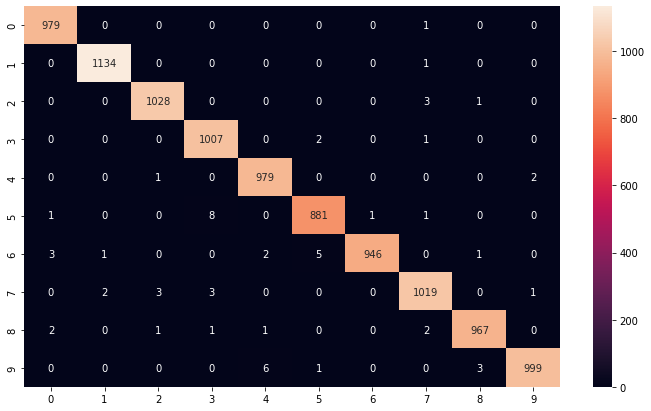

In [9]:
model = torch.jit.load("model.pt", map_location=DEVICE)
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    print("Validation set metrics:")
    print('Accuracy: %.2f%%' % (100 * get_accuracy(y_true, y_pred)))
    print('Precision: %.2f%%' % (100 * get_precision(y_true, y_pred)))
    print('Recall: %.2f%%' % (100 * get_recall(y_true, y_pred)))

cm = build_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)
